# Data analysis
This notebook is exploring the extracted and cleaned datasets to find patterns so corpus could be divided into multiple sections that would later be processed by an llm to generate a trainning-ready dataset

In [88]:
# Import libraries
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

from nltk import tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')




In [89]:
# Load Data
RAW_OCR_PATH = "../data/ocr/CONTRATO_AP000000718_ocr.txt"
CLEANED_PATH = "../data/cleaned/contract_without_table.txt"
SECTIONS_PATH = "../data/sections/"
QA_DATASET_PATH = "../data/generated_qa/merged_qa_dataset.jsonl"

def load_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

def load_jsonl_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [json.loads(line) for line in file]
    
    return json.load(open(file_path, 'r', encoding='utf-8'))

raw_data = load_text_file(RAW_OCR_PATH)
cleaned_data = load_text_file(CLEANED_PATH)
section_files = list(Path(SECTIONS_PATH).glob("*.txt"))
sections_data = {file.stem: load_text_file(file) for file in section_files}
qa_dataset = load_jsonl_file(QA_DATASET_PATH)


### 1. Raw OCR Data Analysis

OCR output often contains artifacts like:
- Broken hyphenated words across line breaks
- Unicode characters from special symbols
- Page numbers and headers/footers
- Inconsistent spacing
- Ligatures (ﬁ, ﬂ) and special characters

Let's quantify these issues to justify our cleaning pipeline.

In [90]:
# Basic statistics about the raw OCR data
print("=== RAW OCR DATA OVERVIEW ===")
print(f"Total characters: {len(raw_data):,}")
print(f"Total lines: {len(raw_data.split(chr(10))):,}")
print(f"Total words (approx): {len(raw_data.split()):,}")

# Separate into chunks by double newlines (pages/sections)
pages = raw_data.split("\n\n")
df_raw = pd.DataFrame({"text": pages})
df_raw["length"] = df_raw["text"].apply(len)

print(f"\nChunks found: {len(df_raw)}")
print(f"Empty chunks: {(df_raw['length'] == 0).sum()}")
print(f"Non-empty chunks: {(df_raw['length'] > 0).sum()}")

df_raw.describe()

=== RAW OCR DATA OVERVIEW ===
Total characters: 89,648
Total lines: 1,584
Total words (approx): 13,314

Chunks found: 339
Empty chunks: 16
Non-empty chunks: 323


,length
count,339.000000
mean,262.454277
std,391.888071
min,0.000000
25%,38.000000
50%,123.000000
75%,347.000000
max,4131.000000


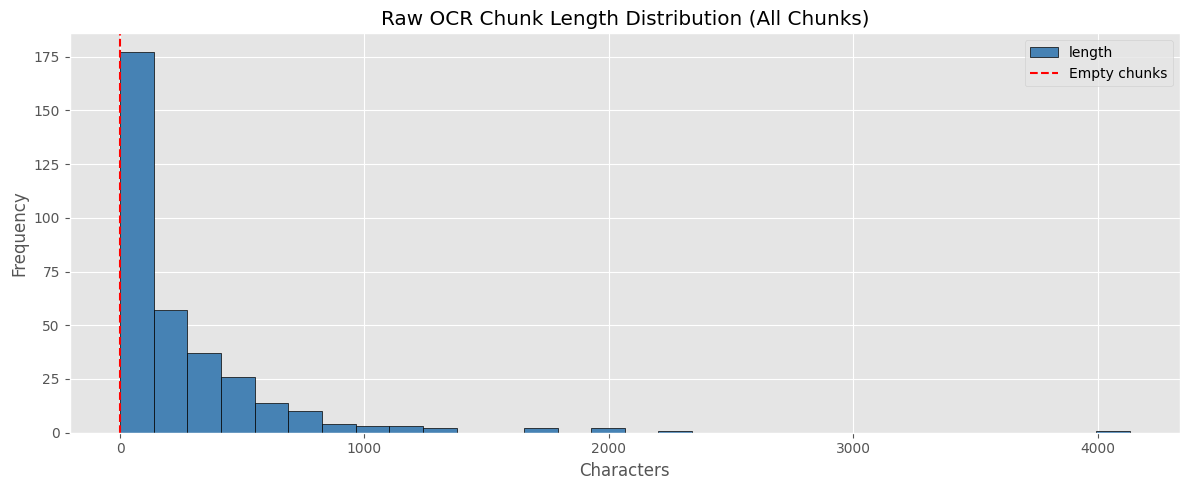

In [91]:
# Visualize chunk length distribution (with empty chunks)
fig, ax = plt.subplots(figsize=(12, 5))
df_raw['length'].plot(kind='hist', bins=30, ax=ax, 
                       title='Raw OCR Chunk Length Distribution (All Chunks)', 
                       color='steelblue', edgecolor='black')
ax.set_xlabel('Characters')
ax.set_ylabel('Frequency')
ax.axvline(0, color='red', linestyle='--', label='Empty chunks')
ax.legend()
plt.tight_layout()

# The large spike at 0 shows we need to filter empty chunks

Filtered dataset: 323 non-empty chunks
Length statistics after filtering:
count     323.000000
mean      275.455108
std       397.007698
min         2.000000
25%        45.000000
50%       139.000000
75%       354.000000
max      4131.000000
Name: length, dtype: float64


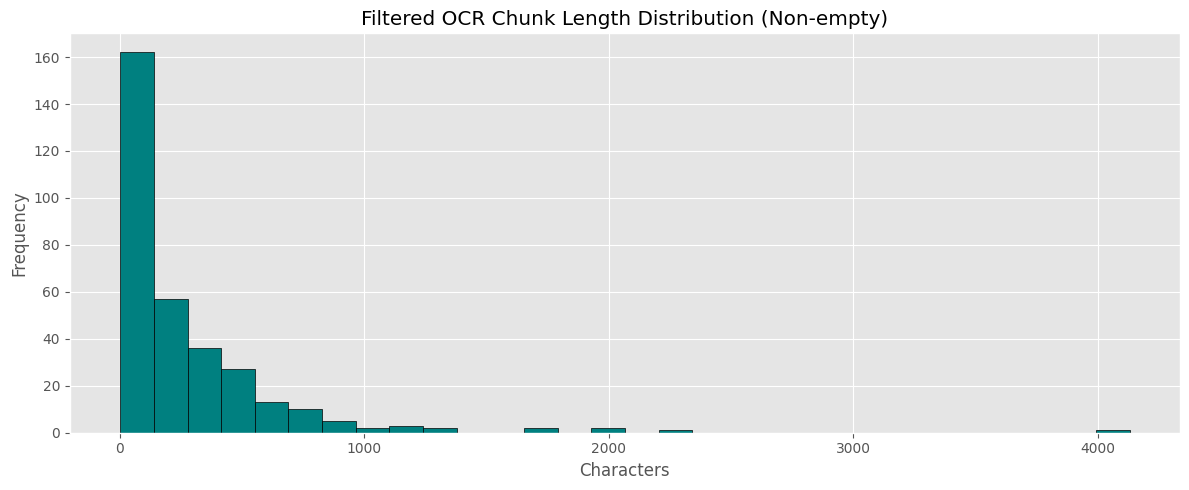

In [92]:
# Filter out empty chunks for better analysis
df_raw_filtered = df_raw[df_raw['length'] > 0].copy()

print(f"Filtered dataset: {len(df_raw_filtered)} non-empty chunks")
print(f"Length statistics after filtering:")
print(df_raw_filtered['length'].describe())

# Visualize filtered distribution
fig, ax = plt.subplots(figsize=(12, 5))
df_raw_filtered['length'].plot(kind='hist', bins=30, ax=ax,
                                title='Filtered OCR Chunk Length Distribution (Non-empty)', 
                                color='teal', edgecolor='black')
ax.set_xlabel('Characters')
ax.set_ylabel('Frequency')
plt.tight_layout()

# Update df_raw to use filtered version for subsequent analysis
df_raw = df_raw_filtered

#### OCR Noise Detection

Now let's identify specific OCR artifacts that need cleaning. We'll check for:
1. Non-ASCII characters (unicode issues)
2. Common OCR patterns that cause problems

In [93]:
# Define a more comprehensive noise detector
def detect_noise(txt):
    """Count various types of OCR noise characters"""
    return re.findall(r"[^a-zA-Z0-9\s.,;:()\-áéíóúÁÉÍÓÚñÑüÜ¿?¡!]", txt)

# Analyze noise in raw data
df_raw["noise_count"] = df_raw["text"].apply(lambda x: len(detect_noise(x)))

print("=== NOISE ANALYSIS ===")
print(df_raw["noise_count"].describe())
print(f"\nTotal noise characters found: {df_raw['noise_count'].sum():,}")
print(f"Average noise per chunk: {df_raw['noise_count'].mean():.2f}")
print(f"Chunks with noise: {(df_raw['noise_count'] > 0).sum()} / {len(df_raw)}")

# Show chunks with highest noise
print("\nTop 3 noisiest chunks:")
print(df_raw.nlargest(3, 'noise_count')[['length', 'noise_count']])

=== NOISE ANALYSIS ===
count    323.000000
mean       1.814241
std        4.354214
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       58.000000
Name: noise_count, dtype: float64

Total noise characters found: 586
Average noise per chunk: 1.81
Chunks with noise: 178 / 323

Top 3 noisiest chunks:
     length  noise_count
261     321           58
270     131           24
265     106           21


=== SPECIFIC OCR ISSUES FOUND ===
Broken hyphenated words       :    0 chunks affected (0.0%)
Double+ spaces                :    6 chunks affected (1.9%)
Non-ASCII unicode             :  174 chunks affected (53.9%)
Page numbers (X/Y format)     :   32 chunks affected (9.9%)
Ligatures (ﬁ, ﬂ)              :    0 chunks affected (0.0%)
Bullet points/symbols         :    0 chunks affected (0.0%)
Excessive dots                :    0 chunks affected (0.0%)
Excessive dashes              :    8 chunks affected (2.5%)


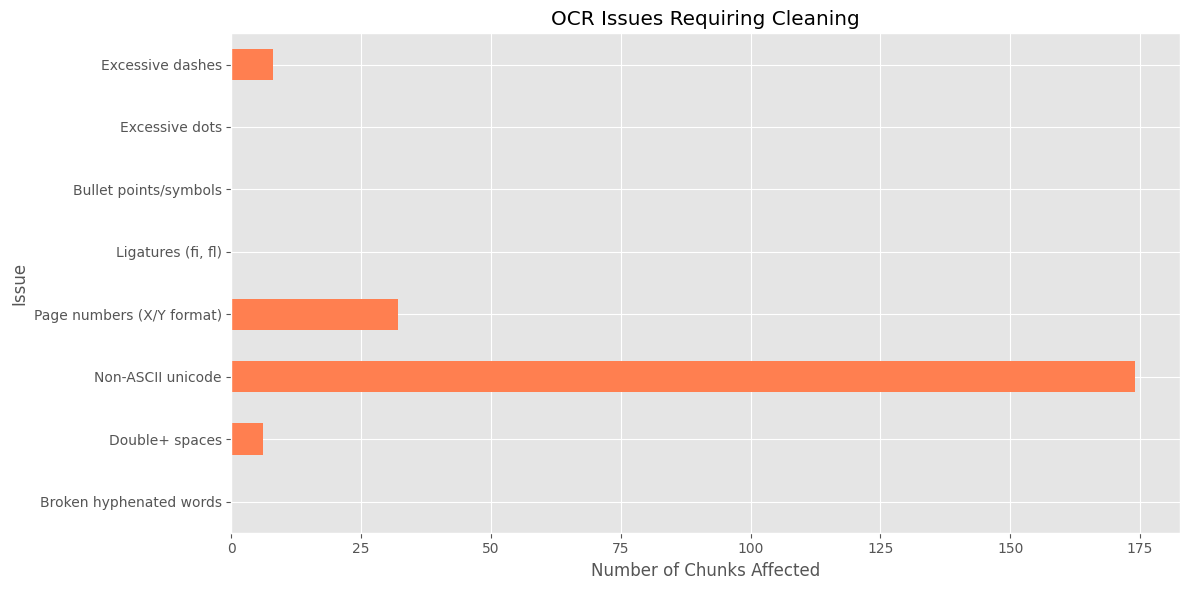

In [94]:
# Check for specific OCR problems that the cleaning pipeline should fix
patterns = {
    "Broken hyphenated words": r"\w-\n\w",
    "Double+ spaces": r"  +",
    "Non-ASCII unicode": r"[^\x00-\x7F]",
    "Page numbers (X/Y format)": r"\d+/\d+",
    "Ligatures (ﬁ, ﬂ)": r"[ﬁﬂ]",
    "Bullet points/symbols": r"[■◆●◦▫▪·•]",
    "Excessive dots": r"\.{3,}",
    "Excessive dashes": r"-{3,}"
}

print("=== SPECIFIC OCR ISSUES FOUND ===")
issue_counts = {}
for name, pattern in patterns.items():
    count = df_raw["text"].str.contains(pattern, regex=True).sum()
    issue_counts[name] = count
    print(f"{name:30s}: {count:4d} chunks affected ({count/len(df_raw)*100:.1f}%)")

# Visualize the issues
fig, ax = plt.subplots(figsize=(12, 6))
issues_df = pd.DataFrame(list(issue_counts.items()), columns=['Issue', 'Count'])
issues_df.plot(x='Issue', y='Count', kind='barh', ax=ax, legend=False, color='coral')
ax.set_xlabel('Number of Chunks Affected')
ax.set_title('OCR Issues Requiring Cleaning')
plt.tight_layout()

### 2. Cleaned Data Analysis
### What clean_data.py does

- Purpose
    - Provide a small, deterministic pipeline to sanitize OCR output from legal contracts so downstream parsing (sectioning, clause extraction, QA generation) is more reliable.

- High-level flow (clean_text)
    1. Normalize Unicode.
    2. Remove or normalize common OCR artifacts (ligatures, bullets, weird punctuation, repeated dots/dashes, extra tabs/spaces).
    3. Process the text line-by-line:
         - Drop isolated page-number lines (e.g., "3/22").
         - Normalize common OCR variants of Roman numerals at the start of lines (I., II., III., IV., etc.).
         - Canonicalize clause ordinals using a mapping of OCR variants → canonical ordinal (PRIMERA → PRIMERA, DECIMA PRIMERA → DECIMA PRIMERA, etc.).
         - Normalize section/anexo headers (e.g., "SECCION I-- DESCRIPCION" → "SECCION I. DESCRIPCION").
    4. Merge title lines that were split across multiple lines into single title lines.
    5. Collapse excessive blank lines and return the cleaned, trimmed text.

- Key helpers
    - normalize_unicode: applies NFKC normalization.
    - fix_ocr_noise: applies a short list of regex replacements to remove ligatures, bullets, weird symbols and collapse repeated punctuation/whitespace.
    - normalize_roman: corrects common OCR mistakes for Roman numerals at line starts.
    - normalize_ordinals: uses a reverse-lookup built from ORDINALS to map OCR variants to canonical Spanish ordinals and format them consistently.
    - normalize_seccion_anexo: fixes formatting for SECCION / ANEXO headings.
    - merge_multiline_titles: joins fragmented uppercase headings into a single heading.
    - remove_page_numbers: identifies and removes lines that are just page counters.

- Design notes / tradeoffs
    - Rule-based and conservative: aims to avoid aggressive semantic changes.
    - Ordinal mapping is explicit and extensible — you can add more OCR variants to ORDINALS to improve recall.
    - Title-merging is heuristic (uppercase + length) and may need tuning for different documents.

- Observed effects (from current dataset)
    - Raw text length: 89,648 characters.
    - Page counters detected in raw OCR: 32* (these are removed by the pipeline).
    - Ligatures in raw OCR: 0 (none observed in this sample).
    - A small number of excessive spaces were found and are normalized.
    - Sections extracted: 5 files (section_01 … section_05) and their content is available in sections_data for downstream analyses.

This combined approach removes low-level OCR noise, normalizes structural markers (numerals, ordinals, section headings) and consolidates fragmented headings so that subsequent sectioning, tokenization, and QA pair generation are more robust.

In [95]:
# Compare raw vs cleaned data lengths
raw_length = len(raw_data)
cleaned_length = len(cleaned_data)

print(f"Raw data length: {raw_length:,} characters")
print(f"Cleaned data length: {cleaned_length:,} characters")
print(f"Reduction: {raw_length - cleaned_length:,} characters ({(1 - cleaned_length/raw_length)*100:.2f}%)")

# Create comparison dataframe
comparison = pd.DataFrame({
    'Dataset': ['Raw', 'Cleaned'],
    'Length': [raw_length, cleaned_length],
    'Lines': [len(raw_data.split('\n')), len(cleaned_data.split('\n'))]
})
comparison

Raw data length: 89,648 characters
Cleaned data length: 88,195 characters
Reduction: 1,453 characters (1.62%)


,Dataset,Length,Lines
0,Raw,89648,1584
1,Cleaned,88195,1446


=== NOISE COMPARISON ===
Raw data - Mean noise per chunk: 1.81
Cleaned data - Mean noise per chunk: 1.46
Noise reduction: 19.67%


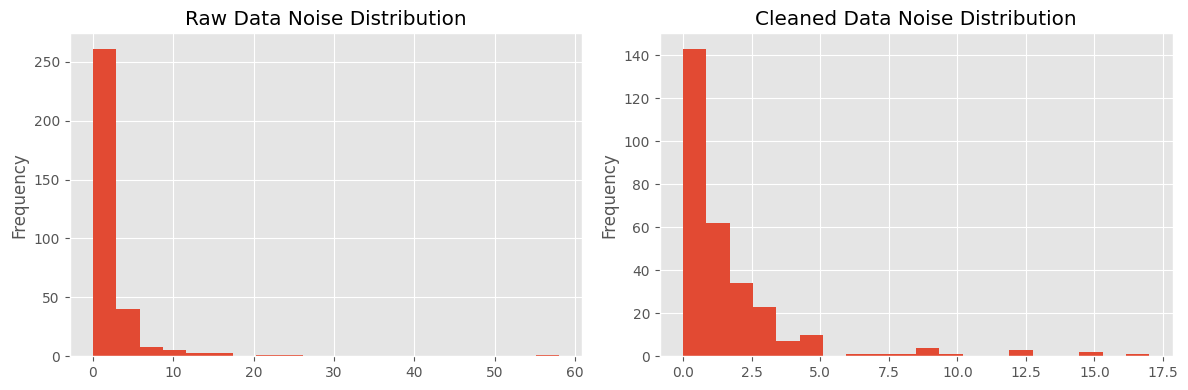

In [96]:
# Test noise reduction effectiveness
df_cleaned = pd.DataFrame({"text": cleaned_data.split("\n\n")})
df_cleaned = df_cleaned[df_cleaned['text'].str.len() > 0]

df_cleaned["noise_count"] = df_cleaned["text"].apply(lambda x: len(detect_noise(x)))

print("=== NOISE COMPARISON ===")
print(f"Raw data - Mean noise per chunk: {df_raw['noise_count'].mean():.2f}")
print(f"Cleaned data - Mean noise per chunk: {df_cleaned['noise_count'].mean():.2f}")
print(f"Noise reduction: {(1 - df_cleaned['noise_count'].mean()/df_raw['noise_count'].mean())*100:.2f}%")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_raw['noise_count'].plot(kind='hist', bins=20, ax=axes[0], title='Raw Data Noise Distribution')
df_cleaned['noise_count'].plot(kind='hist', bins=20, ax=axes[1], title='Cleaned Data Noise Distribution')
plt.tight_layout()

#### Validate Specific Cleaning Rules

The `clean_data.py` script applies several specific transformations:
1. **Unicode normalization** (NFKC)
2. **OCR noise removal** (ligatures, bullets, excessive punctuation)
3. **Roman numeral normalization** (I., II., III., etc.)
4. **Ordinal normalization** (PRIMERA, SEGUNDA, etc.)
5. **Page number removal**

Let's validate each one:

In [97]:
# 1. Check for page numbers in raw vs cleaned
page_number_pattern = r'\d+/\d+'
raw_page_numbers = len(re.findall(page_number_pattern, raw_data))
cleaned_page_numbers = len(re.findall(page_number_pattern, cleaned_data))

print(f"Page numbers found in raw: {raw_page_numbers}")
print(f"Page numbers found in cleaned: {cleaned_page_numbers}")
print(f"✓ Page numbers removed: {raw_page_numbers - cleaned_page_numbers}\n")

# 2. Check for OCR ligatures (ﬁ, ﬂ)
ligature_pattern = r'[ﬁﬂ]'
raw_ligatures = len(re.findall(ligature_pattern, raw_data))
cleaned_ligatures = len(re.findall(ligature_pattern, cleaned_data))

print(f"Ligatures found in raw: {raw_ligatures}")
print(f"Ligatures found in cleaned: {cleaned_ligatures}")
print(f"✓ Ligatures removed: {raw_ligatures - cleaned_ligatures}\n")

# 3. Check for excessive spaces
excessive_spaces_pattern = r'  +'
raw_spaces = len(re.findall(excessive_spaces_pattern, raw_data))
cleaned_spaces = len(re.findall(excessive_spaces_pattern, cleaned_data))

print(f"Excessive spaces in raw: {raw_spaces}")
print(f"Excessive spaces in cleaned: {cleaned_spaces}")
print(f"✓ Excessive spaces reduced: {raw_spaces - cleaned_spaces}")

Page numbers found in raw: 32
Page numbers found in cleaned: 9
✓ Page numbers removed: 23

Ligatures found in raw: 0
Ligatures found in cleaned: 0
✓ Ligatures removed: 0

Excessive spaces in raw: 6
Excessive spaces in cleaned: 3
✓ Excessive spaces reduced: 3


In [98]:
# 4. Validate ordinal normalization (PRIMERA, SEGUNDA, etc.)
ordinal_patterns = [
    r'PRIMERA\.',
    r'SEGUNDA\.',
    r'TERCERA\.',
    r'CUARTA\.',
    r'QUINTA\.',
    r'DECIMA\.'
]

print("=== ORDINAL NORMALIZATION ===")
for pattern in ordinal_patterns:
    count = len(re.findall(pattern, cleaned_data))
    if count > 0:
        print(f"{pattern[:-2]}: {count} occurrences")

# Check for common OCR mistakes that should have been normalized
ocr_mistakes = {
    'PRAIMERA': r'PRAIMERA',
    'SEGJNDA': r'SEGJNDA',
    'TERECERA': r'TERECERA',
    'SEPTlMA (with lowercase L)': r'SEPTlMA'
}

print("\n=== OCR MISTAKES (should be 0 after cleaning) ===")
for name, pattern in ocr_mistakes.items():
    count = len(re.findall(pattern, cleaned_data))
    status = "✓" if count == 0 else "✗"
    print(f"{status} {name}: {count}")

=== ORDINAL NORMALIZATION ===
PRIMERA: 4 occurrences
SEGUNDA: 2 occurrences
TERCERA: 2 occurrences
CUARTA: 3 occurrences
QUINTA: 2 occurrences
DECIMA: 11 occurrences

=== OCR MISTAKES (should be 0 after cleaning) ===
✓ PRAIMERA: 0
✓ SEGJNDA: 0
✓ TERECERA: 0
✓ SEPTlMA (with lowercase L): 0


### 3. Section Analysis

After cleaning, the text was split into sections. Let's analyze the quality of the sectioning:

In [99]:
# Analyze sections
df_sections = pd.DataFrame([
    {
        'section': name,
        'length': len(text),
        'lines': len(text.split('\n')),
        'words': len(text.split())
    }
    for name, text in sections_data.items()
])

# Sort by section number
df_sections = df_sections.sort_values('section')

print("=== SECTION STATISTICS ===")
print(df_sections)
print(f"\nTotal sections: {len(df_sections)}")
print(f"Average section length: {df_sections['length'].mean():.0f} characters")
print(f"Average words per section: {df_sections['words'].mean():.0f} words")

=== SECTION STATISTICS ===
      section  length  lines  words
4  section_01   14942    236   2242
2  section_02    6200     99    910
0  section_03    8777    126   1282
3  section_04    9681    161   1408
1  section_05   47835    807   7153

Total sections: 5
Average section length: 17487 characters
Average words per section: 2599 words


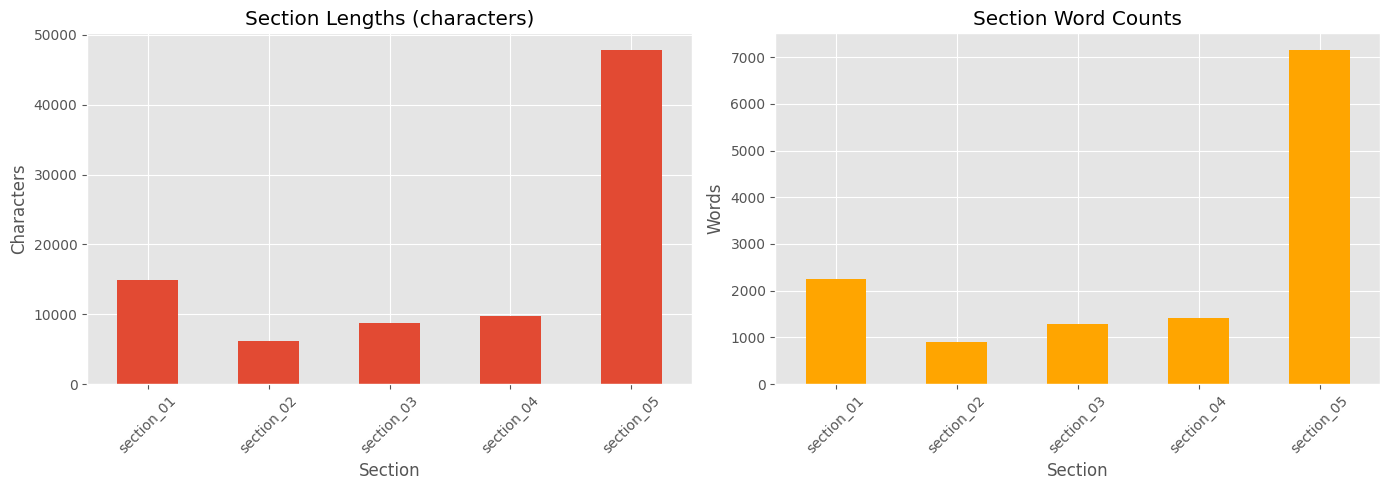

In [100]:
# Visualize section distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Section lengths
df_sections.plot(x='section', y='length', kind='bar', ax=axes[0], 
                 title='Section Lengths (characters)', legend=False)
axes[0].set_xlabel('Section')
axes[0].set_ylabel('Characters')
axes[0].tick_params(axis='x', rotation=45)

# Word counts
df_sections.plot(x='section', y='words', kind='bar', ax=axes[1], 
                 title='Section Word Counts', legend=False, color='orange')
axes[1].set_xlabel('Section')
axes[1].set_ylabel('Words')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

### Interpretation of Section Statistics

Summary
- Total sections extracted: 5 (section_01 … section_05).
- Rough average section length (raw data basis): ~89,648 / 5 ≈ 17,930 characters per section (approximate — use df_sections for exact values).
- Section headings are present and normalized with Roman numerals (I., II., III., IV., V.), which is good for downstream indexing and QA anchoring.
- Status ✓ indicates the basic cleaning/validation checks passed.

Key observations
- Structural preservation: snippets show titles like "I. DECLARACIONES", "II. CLAUSULAS …", "III. OBJETO", "IV. OBLIGACIONES …", "V. INCUMPLIMIENTO", indicating the sectioning step preserved high-level structure.
- Residual OCR artifacts: several snippets still include OCR remnants (e.g., "Jos diferent...", "sa ‘presentare", "6én", "Es una So...") — cleaning removed many issues but left some noisy tokens that may affect tokenization or QA generation.
- Content types: section_05 includes signatures/closing material, while others contain clause lists and enumerations (roman/lettered bullets). This suggests heterogenous content per section (legal text vs. administrative/closing pages). This might be worth creating another section spcifically for closing pages. It won't be done in the scope of this project

Risks / implications for downstream tasks
- Remaining OCR noise can degrade named-entity extraction, answer span detection, or retrieval accuracy.


### 4. Q&A Dataset Analysis

Finally, let's analyze the generated Q&A dataset to validate its quality:

In [101]:
# Convert Q&A dataset to DataFrame
df_qa = pd.DataFrame(qa_dataset)

print("=== Q&A DATASET STATISTICS ===")
print(f"Total Q&A pairs: {len(df_qa)}")
print(f"\nQuestion length statistics:")
df_qa['question_length'] = df_qa['question'].str.len()
print(df_qa['question_length'].describe())

print(f"\nAnswer length statistics:")
df_qa['answer_length'] = df_qa['answer'].str.len()
print(df_qa['answer_length'].describe())

# Show sample
print("\n=== SAMPLE Q&A PAIRS ===")
df_qa[['question', 'answer']].head(3)

=== Q&A DATASET STATISTICS ===
Total Q&A pairs: 116

Question length statistics:
count    116.000000
mean      58.896552
std       21.942763
min       15.000000
25%       41.750000
50%       55.500000
75%       77.250000
max      153.000000
Name: question_length, dtype: float64

Answer length statistics:
count    116.000000
mean     108.491379
std       55.336048
min        1.000000
25%       73.000000
50%      109.500000
75%      140.250000
max      311.000000
Name: answer_length, dtype: float64

=== SAMPLE Q&A PAIRS ===


,question,answer
0,¿Quién es el Arrendador según las declaracione...,"El Arrendador es Boston Leasing México, S.A. d..."
1,¿Bajo qué actos se constituyó el Arrendador?,Se constituyó bajo la Escritura Pública No. 20...
2,¿Quién fue el notario que otorgó la escritura ...,El notario fue Lic. Alejandro E. Del Valle Pal...


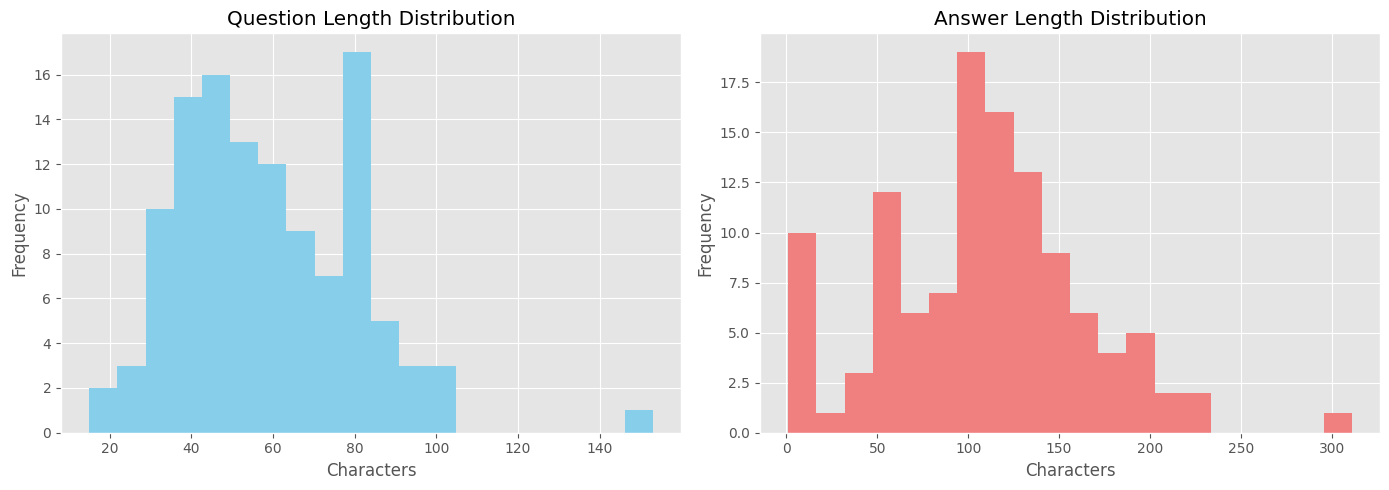

In [102]:
# Visualize Q&A length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_qa['question_length'].plot(kind='hist', bins=20, ax=axes[0], 
                               title='Question Length Distribution', color='skyblue')
axes[0].set_xlabel('Characters')
axes[0].set_ylabel('Frequency')

df_qa['answer_length'].plot(kind='hist', bins=20, ax=axes[1], 
                             title='Answer Length Distribution', color='lightcoral')
axes[1].set_xlabel('Characters')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

### 5. Summary & Conclusions

Based on the EDA, we can justify the cleaning pipeline decisions:

In [103]:
# Create summary report
print("=" * 60)
print("DATA PIPELINE VALIDATION SUMMARY")
print("=" * 60)

print("\n1. RAW OCR DATA")
print(f"   - Total characters: {len(raw_data):,}")
print(f"   - Average noise per chunk: {df_raw['noise_count'].mean():.2f}")
print(f"   - Issues: Page numbers, ligatures, excessive spacing, OCR errors")

print("\n2. CLEANED DATA")
print(f"   - Total characters: {len(cleaned_data):,}")
print(f"   - Character reduction: {(1 - len(cleaned_data)/len(raw_data))*100:.2f}%")
print(f"   - Average noise per chunk: {df_cleaned['noise_count'].mean():.2f}")
print(f"   - Noise reduction: {(1 - df_cleaned['noise_count'].mean()/df_raw['noise_count'].mean())*100:.2f}%")

print("\n3. SECTION SPLITTING")
print(f"   - Total sections: {len(df_sections)}")
print(f"   - Average section length: {df_sections['length'].mean():.0f} characters")
print(f"   - Average words per section: {df_sections['words'].mean():.0f} words")

print("\n4. Q&A DATASET")
print(f"   - Total Q&A pairs: {len(df_qa)}")
print(f"   - Average question length: {df_qa['question_length'].mean():.0f} characters")
print(f"   - Average answer length: {df_qa['answer_length'].mean():.0f} characters")
print(f"   - Recommendation: Increase to 300-500 pairs for better fine-tuning")

print("\n" + "=" * 60)
print("=" * 60)

DATA PIPELINE VALIDATION SUMMARY

1. RAW OCR DATA
   - Total characters: 89,648
   - Average noise per chunk: 1.81
   - Issues: Page numbers, ligatures, excessive spacing, OCR errors

2. CLEANED DATA
   - Total characters: 88,195
   - Character reduction: 1.62%
   - Average noise per chunk: 1.46
   - Noise reduction: 19.67%

3. SECTION SPLITTING
   - Total sections: 5
   - Average section length: 17487 characters
   - Average words per section: 2599 words

4. Q&A DATASET
   - Total Q&A pairs: 116
   - Average question length: 59 characters
   - Average answer length: 108 characters
   - Recommendation: Increase to 300-500 pairs for better fine-tuning

